# Notes

Estimation: 
- Model-Fit ohne Start-Parameter (Start-Params abgelitten aus Non-switching-Modell): LinAlgebra-Fehler
- Model-Fit ohne Start-Parameter: Schneller Error
- Model-Fit mit Start-Params & Standardisierung: Funktioniert soweit

Aktueller Stand:
- params passen nicht zu denen die rauskommen sollen
- Was bedeuten die params? 


Sonst:
- Das KimYoo1995 Modell braucht multivariate Time-Series. Passend zu Chauvet / Piget

# Model definition

In [99]:
import numpy as np
from numpy.testing import assert_allclose
from statsmodels.tsa.statespace.regime_switching.tools import \
        MarkovSwitchingParams
from statsmodels.tsa.statespace.regime_switching.switching_dynamic_factor \
        import _DynamicFactorWithFactorIntercept, SwitchingDynamicFactor

class KimYoo1995NonswitchingModel(_DynamicFactorWithFactorIntercept):
    '''
    This is dynamic factor model with some restrictions on parameters.
    See http://econ.korea.ac.kr/~cjkim/MARKOV/programs/sw_ms.opt.
    '''

    def __init__(self, endog, k_factors, factor_order, **kwargs):

        super(KimYoo1995NonswitchingModel, self).__init__(endog, k_factors,
                factor_order, **kwargs)

        k_endog = self.k_endog
        error_order = self.error_order

        offset = 0
        self._gamma_idx = np.s_[offset:offset + k_endog + k_factors - 1]
        offset += k_endog + k_factors - 1
        self._phi_idx = np.s_[offset:offset + error_order]
        offset += error_order
        self._psi_idx = np.s_[offset:offset + k_endog * error_order]
        offset += k_endog * error_order
        self._sigma_idx = np.s_[offset:offset + k_endog]
        offset += k_endog
        self._mu_idx = np.s_[offset]
        self._params_without_intercept_idx = np.s_[:offset]
        self._kimyoo_k_params_without_intercept = offset
        offset += 1

        self.kimyoo_k_params = offset

        # For the sake of clarity
        self._base_class_k_params = self.k_params_with_factor_intercept

    def _get_dynamic_factor_params(self, params_without_intercept):
        '''
        params_without_intercept - just a prefix of parameters vector, since
        intercept is the last value
        '''

        dtype = self.ssm.dtype
        k_endog = self.k_endog
        k_factors = self.k_factors
        factor_order = self.factor_order
        error_order = self.error_order

        dynamic_factor_params = np.zeros((self.dynamic_factor_k_params,),
                dtype=dtype)

        # 1. Factor loadings

        factor_loadings_matrix = np.zeros((k_endog, k_factors), dtype=dtype)

        gammas = params_without_intercept[self._gamma_idx]

        factor_loadings_matrix[:, 0] = gammas[:k_endog]
        factor_loadings_matrix[-1, 1:] = gammas[k_endog:]

        dynamic_factor_params[self._params_loadings] = \
                factor_loadings_matrix.ravel()

        # 2. Error covs

        dynamic_factor_params[self._params_error_cov] = \
                params_without_intercept[self._sigma_idx]

        # 3. Factor transition

        phi = params_without_intercept[self._phi_idx]


        # `factor_order` == 1, so this essentially is a square matrix
        factor_transition_params = np.zeros((k_factors,
                k_factors * factor_order), dtype=dtype)

        # TODO: check order of parameters

        factor_transition_params[0, :k_factors - 1] = phi
        factor_transition_params[1:, :-1] = np.identity(k_factors - 1,
                dtype=dtype)

        dynamic_factor_params[self._params_factor_transition] = \
                factor_transition_params.ravel()

        # 4. Error transition

        psi = params_without_intercept[self._psi_idx]

        dynamic_factor_params[self._params_error_transition] = psi

        return dynamic_factor_params

    def _get_params_without_intercept(self, dynamic_factor_params):
        '''
        reverse to previous
        '''

        dtype = self.ssm.dtype
        k_endog = self.k_endog
        k_factors = self.k_factors
        factor_order = self.factor_order
        error_order = self.error_order

        params_without_intercept = np.zeros(( \
                self._kimyoo_k_params_without_intercept,),
                dtype=dtype)

        # 1. Factor loadings

        factor_loadings_matrix = \
                dynamic_factor_params[self._params_loadings].reshape( \
                k_endog, k_factors)

        gammas = np.zeros((k_endog + k_factors - 1,), dtype=dtype)

        gammas[:k_endog] = factor_loadings_matrix[:, 0]
        gammas[k_endog:] = factor_loadings_matrix[-1, 1:]

        params_without_intercept[self._gamma_idx] = gammas

        # 2. Error covs

        params_without_intercept[self._sigma_idx] = dynamic_factor_params[ \
                self._params_error_cov]

        # 3. Factor transition

        # `factor_order` == 1, so this essentially is a square matrix
        factor_transition_params = \
                dynamic_factor_params[self._params_factor_transition \
                ].reshape(k_factors, k_factors * factor_order)

        params_without_intercept[self._phi_idx] = factor_transition_params[0,
                :k_factors - 1]

        # 4. Error transition

        psi = dynamic_factor_params[self._params_error_transition]

        params_without_intercept[self._psi_idx] = psi

        return params_without_intercept

    def _get_base_class_params(self, params):

        dtype = self.ssm.dtype

        base_class_params = np.zeros((self._base_class_k_params,), dtype=dtype)

        base_class_params[self._dynamic_factor_params_idx] = \
                self._get_dynamic_factor_params(
                params[self._params_without_intercept_idx])

        base_class_params[self._factor_intercept_idx] = params[self._mu_idx]

        return base_class_params

    def _get_params(self, base_class_params):

        dtype = self.ssm.dtype

        params_without_intercept = self._get_params_without_intercept(
                base_class_params[self._dynamic_factor_params_idx])

        params = np.zeros((self.kimyoo_k_params,), dtype=dtype)

        params[self._params_without_intercept_idx] = params_without_intercept

        params[self._mu_idx] = base_class_params[self._factor_intercept_idx]

        return params

    @property
    def start_params(self):

        base_start_params = super(KimYoo1995NonswitchingModel,
                self).start_params

        return self._get_params(base_start_params)

    def transform_params(self, unconstrained):

        unconstr_base_class_params = self._get_base_class_params(unconstrained)

        constr_base_class_params = super(KimYoo1995NonswitchingModel,
                self).transform_params(unconstr_base_class_params)

        constrained = self._get_params(constr_base_class_params)

        return constrained

    def untransform_params(self, constrained):

        constr_base_class_params = self._get_base_class_params(constrained)

        unconstr_base_class_params = super(KimYoo1995NonswitchingModel,
                self).untransform_params(constr_base_class_params)

        unconstrained = self._get_params(unconstr_base_class_params)

        return unconstrained

    def update(self, params, **kwargs):

        dtype = self.ssm.dtype
        k_states = self.k_states

        base_class_params = self._get_base_class_params(params)

        super(KimYoo1995NonswitchingModel, self).update(base_class_params,
                **kwargs)

        # Filter initialization.

        state_intercept = self['state_intercept']

        transition = self['transition']

        raveled_state_cov = (self['selection'].dot(self['state_cov']).dot(
                self['selection'].T)).reshape(-1, 1)

        initial_state = np.linalg.inv(np.identity(k_states, dtype=dtype) - \
                transition).dot(state_intercept).ravel()

        transition_outer_sqr = np.zeros((k_states * k_states,
                k_states * k_states), dtype=dtype)

        for i in range(k_states):
            for j in range(k_states):
                transition_outer_sqr[i * k_states:i * k_states + k_states,
                        j * k_states:j * k_states + k_states] = \
                        transition * transition[i, j]

        initial_state_cov = np.linalg.inv(np.identity(k_states * k_states,
                dtype=dtype) - transition_outer_sqr).dot(raveled_state_cov
                ).reshape(k_states, k_states).T

        self.initialize_known(initial_state, initial_state_cov)


class KimYoo1995Model(SwitchingDynamicFactor):
    '''
    This is switching dynamic factor model with some restrictions on
    parameters. See http://econ.korea.ac.kr/~cjkim/MARKOV/programs/sw_ms.opt.
    '''

    def __init__(self, k_regimes, endog, k_factors, factor_order, **kwargs):

        super(KimYoo1995Model, self).__init__(k_regimes, endog, k_factors,
                factor_order, **kwargs)

        # we need this instance because of its useful methods
        # `_get_dynamic_factor_params`, `_get_params_without_intercept` and
        # others
        self._nonswitching_model = KimYoo1995NonswitchingModel(endog,
                k_factors, factor_order, **kwargs)

        # For the sake of clarity
        self._base_class_parameters = self.parameters

        # params vector for this model differs from params vector in
        # `SwitchingDynamicFactor`.
        self._kimyoo_parameters = MarkovSwitchingParams(k_regimes)

        self._kimyoo_parameters['regime_transition'] = [False] * k_regimes * \
                (k_regimes - 1)

        # Number of nonswitching params is equal to number of parameters in
        # nonswitching model, except of factor intercept (1 value).
        self._kimyoo_parameters['nonswitching_params'] = [False] * \
                (self._nonswitching_model.kimyoo_k_params - 1)

        self._kimyoo_parameters['factor_intercept'] = [True]

        # A dirty hack, required, because Kim-Yoo model's specification is a
        # little different from Statsmodels one.
        self['state_cov', :k_factors, :k_factors] = 0
        self['state_cov', 0, 0] = 1

    def _get_base_class_params(self, params):

        dtype = self.ssm.dtype

        base_class_params = np.zeros((self._base_class_parameters.k_params,),
                dtype=dtype)

        base_class_params[self._base_class_parameters['regime_transition']] = \
                params[self._kimyoo_parameters['regime_transition']]

        params_without_intercept = params[self._kimyoo_parameters[
                'nonswitching_params']]

        base_class_params[self._base_class_parameters['dynamic_factor']] = \
                self._nonswitching_model._get_dynamic_factor_params(
                params_without_intercept)

        base_class_params[self._base_class_parameters['factor_intercept']] = \
                params[self._kimyoo_parameters['factor_intercept']]

        return base_class_params

    def _get_params(self, base_class_params):

        dtype = self.ssm.dtype

        params = np.zeros((self._kimyoo_parameters.k_params,), dtype=dtype)

        params[self._kimyoo_parameters['regime_transition']] = \
                base_class_params[self._base_class_parameters[
                'regime_transition']]

        dynamic_factor_params = base_class_params[self._base_class_parameters[
                'dynamic_factor']]

        params[self._kimyoo_parameters['nonswitching_params']] = \
                self._nonswitching_model._get_params_without_intercept(
                dynamic_factor_params)

        params[self._kimyoo_parameters['factor_intercept']] = \
                base_class_params[self._base_class_parameters[
                'factor_intercept']]

        return params

    @property
    def start_params(self):

        dtype = self.ssm.dtype

        base_start_params = super(KimYoo1995Model, self).start_params

        return self._get_params(base_start_params)

    def get_nonswitching_model(self):

        # don't need to instantiate a new model, since we already have one
        return self._nonswitching_model

    def update_params(self, params, nonswitching_model_params):

        base_class_params = self._get_base_class_params(params)

        nonswitching_base_class_params = \
                self._nonswitching_model._get_base_class_params(
                nonswitching_model_params)

        updated_base_class_params = super(KimYoo1995Model,
                self).update_params(base_class_params,
                nonswitching_base_class_params)

        return self._get_params(updated_base_class_params)

    def transform_model_params(self, unconstrained):

        unconstr_base_class_params = self._get_base_class_params(unconstrained)

        constr_base_class_params = super(KimYoo1995Model,
                self).transform_model_params(unconstr_base_class_params)

        return self._get_params(constr_base_class_params)

    def untransform_model_params(self, constrained):

        constr_base_class_params = self._get_base_class_params(constrained)

        unconstr_base_class_params = super(KimYoo1995Model,
                self).untransform_model_params(constr_base_class_params)

        return self._get_params(unconstr_base_class_params)

    def update(self, params, **kwargs):

        dtype = self.ssm.dtype
        k_regimes = self.k_regimes
        k_states = self.k_states

        base_class_params = self._get_base_class_params(params)

        super(KimYoo1995Model, self).update(base_class_params, **kwargs)

        # Filter initialization.

        initial_state = np.zeros((k_regimes, k_states), dtype=dtype)

        state_intercept = self['state_intercept']

        transition = self['transition'][0]

        raveled_state_cov = self['state_cov'][0].reshape(-1, 1)

        for i in range(k_regimes):
            initial_state[i] = np.linalg.inv(np.identity(k_states,
                    dtype=dtype) - transition).dot(state_intercept[i]
                    ).ravel()

        transition_outer_sqr = np.zeros((k_states * k_states,
                k_states * k_states), dtype=dtype)

        for i in range(k_states):
            for j in range(k_states):
                transition_outer_sqr[i * k_states:i * k_states + k_states,
                        j * k_states:j * k_states + k_states] = \
                        transition * transition[i, j]

        initial_state_cov = np.linalg.inv(np.identity(k_states * k_states,
                dtype=dtype) - transition_outer_sqr).dot(raveled_state_cov
                ).reshape(k_states, k_states).T

        self.initialize_known(initial_state, initial_state_cov)


class KimYoo1995(object):

    @classmethod
    def setup_class(cls, with_standardizing):

        cls.dtype = np.float64
        dtype = cls.dtype

        cls.k_regimes = 2
        cls.k_factors = 3
        cls.factor_order = 1
        cls.error_order = 2
        cls.enforce_stationarity = False

        cls.true = results_kim_yoo1995.sw_ms

        ip = np.array(cls.true['data']['ip'], dtype=dtype)
        gmyxpq = np.array(cls.true['data']['gmyxpq'], dtype=dtype)
        mtq = np.array(cls.true['data']['mtq'], dtype=dtype)
        lpnag = np.array(cls.true['data']['lpnag'], dtype=dtype)
        cls.dcoinc = np.array(cls.true['data']['dcoinc'], dtype=dtype)

        yy = np.zeros((432, 4), dtype=dtype)
        yy[:, 0] = (np.log(ip[1:]) - np.log(ip[:-1])) * 100
        yy[:, 1] = (np.log(gmyxpq[1:]) - np.log(gmyxpq[:-1])) * 100
        yy[:, 2] = (np.log(mtq[1:]) - np.log(mtq[:-1])) * 100
        yy[:, 3] = (np.log(lpnag[1:]) - np.log(lpnag[:-1])) * 100

        yy -= yy.mean(axis=0)

        if with_standardizing:
            yy /= yy.std(axis=0)

        cls.obs = yy

        cls.model = KimYoo1995Model(cls.k_regimes, cls.obs,
                cls.k_factors, cls.factor_order, error_order=cls.error_order,
                loglikelihood_burn=cls.true['start'],
                enforce_stationarity=cls.enforce_stationarity)



# Data

## def

In [100]:
sw_ms = {
    'data': {
        'ip': [
            36.0, 36.7, 37.2, 38.0, 38.6, 38.6, 37.7, 36.4, 36.4, 36.1,
            36.3, 38.6, 39.6, 39.2, 38.9, 38.6, 38.5, 38.1, 37.9, 37.9,
            37.5, 37.4, 36.9, 36.2, 36.3, 36.2, 36.4, 37.2, 37.7, 38.3,
            38.7, 39.1, 39.0, 39.8, 40.4, 40.7, 40.4, 41.1, 41.3, 41.4,
            41.3, 41.2, 41.6, 41.7, 41.9, 42.0, 42.2, 42.2, 42.5, 42.9,
            43.2, 43.6, 44.1, 44.3, 44.1, 44.2, 44.6, 44.9, 45.1, 45.1,
            45.5, 45.8, 45.8, 46.5, 46.8, 46.9, 47.2, 47.5, 47.7, 47.0,
            48.5, 49.1, 49.6, 49.9, 50.6, 50.8, 51.2, 51.6, 52.1, 52.3,
            52.4, 52.9, 53.2, 53.8, 54.4, 54.7, 55.5, 55.5, 56.1, 56.3,
            56.6, 56.7, 57.2, 57.6, 57.2, 57.3, 57.6, 57.0, 56.6, 57.2,
            56.7, 56.7, 56.5, 57.6, 57.5, 58.0, 58.8, 59.5, 59.4, 59.6,
            59.8, 59.9, 60.6, 60.8, 60.7, 60.9, 61.1, 61.2, 62.0, 62.2,
            62.6, 63.0, 63.5, 63.2, 63.0, 63.6, 63.9, 64.1, 64.1, 64.1,
            63.5, 63.3, 62.1, 62.1, 62.0, 61.9, 61.8, 61.6, 61.7, 61.6,
            61.2, 60.0, 59.6, 61.0, 61.5, 61.3, 61.3, 61.6, 61.9, 62.2,
            62.0, 61.7, 62.7, 63.1, 63.4, 64.1, 65.6, 66.0, 66.5, 67.6,
            67.5, 67.7, 67.6, 68.5, 69.2, 70.2, 71.1, 71.7, 71.8, 72.8,
            72.8, 73.0, 73.4, 73.9, 74.4, 74.3, 74.9, 75.2, 75.2, 74.0,
            73.0, 72.7, 73.0, 72.9, 73.8, 74.0, 73.6, 73.4, 73.7, 73.2,
            71.1, 68.1, 66.3, 65.3, 64.1, 64.7, 64.5, 65.3, 65.7, 66.9,
            67.6, 67.9, 68.6, 69.1, 69.9, 71.1, 70.9, 71.2, 72.0, 72.1,
            72.5, 72.9, 73.1, 73.4, 74.6, 75.2, 75.5, 75.9, 76.6, 77.7,
            78.3, 78.9, 78.9, 79.0, 79.4, 79.4, 79.5, 79.1, 78.8, 79.0,
            80.0, 82.0, 82.3, 83.1, 83.3, 83.6, 84.1, 84.5, 85.2, 85.4,
            85.1, 85.8, 86.1, 85.2, 86.2, 86.1, 85.6, 85.3, 85.5, 86.0,
            85.7, 85.6, 85.9, 86.2, 86.2, 84.5, 82.5, 81.5, 81.2, 82.4,
            83.5, 84.0, 85.5, 85.9, 85.2, 85.4, 85.7, 85.0, 85.6, 86.1,
            87.1, 86.9, 86.5, 85.8, 84.8, 84.1, 82.4, 84.2, 83.7, 83.2,
            82.7, 82.4, 82.0, 81.6, 81.0, 80.3, 80.0, 79.3, 80.8, 80.7,
            81.3, 82.3, 83.2, 83.7, 85.3, 86.5, 87.9, 88.6, 88.8, 89.2,
            91.0, 90.9, 91.9, 92.4, 93.0, 93.5, 93.9, 94.0, 93.9, 93.2,
            93.3, 92.8, 93.1, 93.8, 94.1, 94.5, 94.7, 94.4, 94.1, 94.5,
            95.0, 94.2, 94.6, 95.6, 96.1, 95.5, 94.6, 94.8, 94.7, 94.3,
            94.8, 94.9, 95.0, 95.6, 96.3, 96.8, 96.507, 97.885, 98.249,
            98.774, 99.396, 100.251, 100.616, 100.92, 100.716, 102.052,
            102.158, 102.825, 103.157, 103.389, 103.401, 104.254, 103.982,
            104.012, 104.61, 105.206, 104.684, 104.994, 105.599, 106.271,
            106.641, 106.157, 107.072, 107.071, 106.702, 106.36, 105.306,
            105.845, 105.376, 104.988, 105.357, 106.06, 105.519, 106.091,
            106.423, 105.722, 106.479, 106.669, 106.492, 106.798, 106.815,
            106.322, 104.967, 104.538, 104.005, 103.105, 102.098, 102.614,
            103.466, 104.419, 104.703, 104.813, 105.748, 105.634, 105.583,
            105.19, 104.881, 105.783, 106.449, 106.929, 107.502, 107.153,
            108.07, 108.011, 108.2, 108.845, 109.915, 110.447, 110.65,
            111.305, 111.395, 111.379, 111.125, 111.462, 111.952, 112.193,
            112.542, 112.653, 113.699, 114.711, 114.744, 115.626, 116.618,
            116.714, 117.351, 118.023, 118.231, 119.128, 119.0, 119.5, 120.3,
            121.7, 122.2
        ],
        'gmyxpq': [
            1318.7, 1326.1, 1338.1, 1349.3, 1354.6, 1359.3, 1360.7, 1346.1,
            1344.1, 1346.7, 1366.1, 1381.6, 1387.1, 1379.9, 1378.0, 1380.7,
            1390.9, 1390.5, 1388.0, 1388.4, 1385.1, 1385.6, 1383.0, 1377.9,
            1389.5, 1390.9, 1391.3, 1400.4, 1408.7, 1415.9, 1417.6, 1425.5,
            1425.8, 1439.8, 1454.8, 1462.4, 1459.1, 1464.3, 1475.7, 1481.9,
            1480.9, 1491.1, 1497.5, 1495.7, 1494.4, 1500.7, 1505.3, 1512.3,
            1505.6, 1515.5, 1515.1, 1520.7, 1529.1, 1530.7, 1533.4, 1541.5,
            1552.3, 1564.1, 1564.9, 1573.7, 1576.5, 1586.2, 1593.8, 1604.5,
            1609.6, 1618.2, 1628.2, 1636.3, 1646.2, 1649.7, 1663.7, 1677.1,
            1676.5, 1678.3, 1686.4, 1691.9, 1708.8, 1722.0, 1726.3, 1735.0,
            1738.8, 1759.5, 1775.6, 1784.3, 1783.1, 1786.1, 1791.1, 1798.7,
            1806.6, 1817.4, 1822.9, 1830.0, 1829.1, 1841.4, 1846.5, 1848.4,
            1863.9, 1863.2, 1865.3, 1864.4, 1872.1, 1880.5, 1889.2, 1897.1,
            1893.7, 1897.8, 1909.1, 1923.2, 1922.1, 1937.9, 1941.0, 1948.3,
            1961.7, 1971.6, 1982.3, 1984.5, 2000.3, 2002.1, 2011.4, 2022.2,
            2020.1, 2025.1, 2037.2, 2040.2, 2051.0, 2056.0, 2074.2, 2079.9,
            2086.9, 2093.0, 2098.3, 2097.4, 2092.0, 2087.2, 2090.6, 2098.3,
            2093.0, 2087.6, 2096.6, 2101.7, 2101.1, 2091.7, 2091.7, 2093.1,
            2104.6, 2103.8, 2105.4, 2107.0, 2116.7, 2114.4, 2117.3, 2130.3,
            2130.2, 2134.9, 2147.2, 2166.6, 2177.2, 2188.3, 2195.1, 2208.1,
            2215.8, 2199.2, 2232.7, 2256.6, 2267.8, 2289.8, 2314.0, 2327.8,
            2331.1, 2331.6, 2330.8, 2324.0, 2346.6, 2355.5, 2355.0, 2368.6,
            2379.6, 2409.3, 2428.2, 2421.8, 2390.7, 2364.1, 2334.9, 2322.9,
            2324.4, 2330.2, 2334.8, 2327.5, 2330.3, 2337.2, 2314.7, 2305.3,
            2276.6, 2255.9, 2259.0, 2256.5, 2264.0, 2271.2, 2273.5, 2294.9,
            2309.9, 2326.6, 2328.9, 2328.0, 2349.0, 2362.5, 2370.7, 2380.6,
            2391.0, 2388.2, 2392.3, 2398.1, 2402.1, 2401.9, 2424.9, 2432.3,
            2432.8, 2439.8, 2447.1, 2452.7, 2469.9, 2473.8, 2496.8, 2510.8,
            2524.5, 2527.7, 2534.5, 2546.8, 2550.0, 2562.3, 2590.8, 2620.4,
            2623.4, 2640.0, 2642.0, 2654.8, 2668.7, 2685.4, 2692.5, 2702.8,
            2701.6, 2714.6, 2726.6, 2712.6, 2711.3, 2717.9, 2725.7, 2727.0,
            2728.8, 2737.0, 2744.2, 2749.7, 2753.7, 2744.1, 2731.4, 2706.4,
            2686.5, 2684.0, 2676.4, 2692.2, 2706.6, 2741.9, 2760.9, 2781.2,
            2776.2, 2772.6, 2775.7, 2775.9, 2772.4, 2781.5, 2799.9, 2814.3,
            2813.5, 2805.3, 2793.9, 2781.9, 2768.6, 2776.1, 2781.7, 2800.5,
            2806.1, 2788.1, 2776.4, 2771.7, 2762.0, 2758.7, 2756.5, 2767.6,
            2767.8, 2760.2, 2764.4, 2778.0, 2791.7, 2800.3, 2814.1, 2804.3,
            2826.3, 2862.2, 2879.3, 2900.7, 2922.4, 2963.6, 2982.9, 2987.2,
            2986.8, 3007.7, 3023.7, 3038.6, 3064.3, 3046.0, 3060.1, 3098.8,
            3081.3, 3092.9, 3103.6, 3118.7, 3098.2, 3109.9, 3104.1, 3104.5,
            3105.1, 3123.6, 3118.7, 3154.3, 3139.7, 3158.7, 3187.4, 3227.7,
            3212.3, 3199.5, 3198.3, 3211.0, 3216.3, 3206.7, 3209.9, 3233.1,
            3220.2, 3240.1, 3240.6, 3242.8, 3233.5, 3232.3, 3242.1, 3255.8,
            3258.5, 3309.4, 3292.7, 3345.5, 3307.9, 3322.3, 3335.3, 3342.1,
            3341.6, 3350.7, 3355.2, 3357.6, 3362.6, 3410.6, 3386.5, 3411.5,
            3427.6, 3445.5, 3455.2, 3448.3, 3429.0, 3422.5, 3429.0, 3424.8,
            3414.2, 3432.1, 3447.5, 3457.2, 3457.4, 3476.7, 3487.8, 3495.0,
            3481.5, 3482.6, 3485.1, 3464.3, 3461.2, 3429.0, 3439.3, 3467.5,
            3419.2, 3414.3, 3426.2, 3418.3, 3415.8, 3425.4, 3410.4, 3404.6,
            3410.5, 3412.8, 3401.1, 3431.7, 3412.1, 3440.8, 3445.8, 3447.5,
            3446.9, 3446.3, 3449.4, 3455.9, 3473.1, 3496.7, 3501.1, 3706.5,
            3461.0, 3465.2, 3475.1, 3523.8, 3533.0, 3514.8, 3506.0, 3543.1,
            3539.6, 3556.1, 3571.8, 3589.3, 3566.9, 3618.9, 3629.0, 3641.9,
            3652.7, 3649.3, 3654.2, 3665.0, 3683.6, 3735.7, 3727.3, 3751.4,
            3760.8],
        'mtq': [
            177579.0, 180295.0, 182424.0, 185177.0, 187213.0, 187464.0,
            186905.0, 180702.0, 180205.0, 180599.0, 181001.0, 186020.0,
            189271.0, 188409.0, 187454.0, 187916.0, 185445.0, 185299.0,
            184402.0, 183416.0, 185475.0, 184494.0, 182100.0, 182475.0,
            178627.0, 179133.0, 182209.0, 181214.0, 183946.0, 187282.0,
            185026.0, 189399.0, 190051.0, 192566.0, 194393.0, 195194.0,
            195352.0, 195537.0, 198194.0, 198356.0, 198124.0, 197286.0,
            198071.0, 199471.0, 198952.0, 200913.0, 203713.0, 200284.0,
            201169.0, 204347.0, 204465.0, 206370.0, 204950.0, 206727.0,
            209795.0, 208574.0, 208791.0, 211015.0, 208723.0, 213334.0,
            214560.0, 214575.0, 214008.0, 217537.0, 219879.0, 219279.0,
            222959.0, 222257.0, 224339.0, 220983.0, 223310.0, 230443.0,
            229885.0, 230640.0, 235579.0, 236142.0, 233649.0, 234691.0,
            238911.0, 237557.0, 237547.0, 239786.0, 243138.0, 243988.0,
            246684.0, 246953.0, 250964.0, 249027.0, 248149.0, 250815.0,
            249321.0, 250896.0, 250438.0, 251112.0, 250109.0, 251214.0,
            252621.0, 252020.0, 253265.0, 253761.0, 253796.0, 254250.0,
            254249.0, 257298.0, 256699.0, 254730.0, 261763.0, 267141.0,
            265864.0, 264932.0, 267361.0, 267119.0, 268528.0, 271129.0,
            274384.0, 270066.0, 271294.0, 275450.0, 277670.0, 275368.0,
            275855.0, 276373.0, 277968.0, 279301.0, 278781.0, 278746.0,
            280072.0, 281564.0, 283152.0, 285865.0, 282135.0, 281792.0,
            279400.0, 279282.0, 276126.0, 274134.0, 277364.0, 278207.0,
            278441.0, 277112.0, 276793.0, 272273.0, 267731.0, 276499.0,
            279715.0, 281661.0, 282908.0, 284258.0, 286259.0, 289727.0,
            288174.0, 286277.0, 289563.0, 290422.0, 295093.0, 297156.0,
            300201.0, 297396.0, 302716.0, 305077.0, 306605.0, 307938.0,
            308992.0, 314304.0, 317743.0, 321720.0, 326386.0, 331125.0,
            335572.0, 336568.0, 334362.0, 332728.0, 331496.0, 330711.0,
            335267.0, 330662.0, 330325.0, 337743.0, 342034.0, 337065.0,
            338234.0, 337134.0, 340708.0, 339270.0, 340309.0, 338974.0,
            340112.0, 335795.0, 332271.0, 327459.0, 323059.0, 312343.0,
            314166.0, 312571.0, 303419.0, 308306.0, 307936.0, 310588.0,
            313554.0, 315628.0, 316972.0, 317251.0, 315777.0, 319167.0,
            327307.0, 329157.0, 331645.0, 334615.0, 333800.0, 337423.0,
            338535.0, 337677.0, 338062.0, 334574.0, 340175.0, 350306.0,
            348170.0, 352455.0, 356339.0, 357357.0, 356424.0, 359677.0,
            360474.0, 360774.0, 361351.0, 362999.0, 365148.0, 369826.0,
            361385.0, 368449.0, 371288.0, 381447.0, 380766.0, 381737.0,
            379394.0, 385200.0, 383969.0, 388325.0, 390207.0, 391501.0,
            390311.0, 386651.0, 397051.0, 384979.0, 395454.0, 389307.0,
            389666.0, 389991.0, 388185.0, 388053.0, 387094.0, 385697.0,
            392835.0, 387465.0, 378012.0, 370276.0, 363974.0, 362525.0,
            368215.0, 369349.0, 377120.0, 384277.0, 383965.0, 384437.0,
            386997.0, 385511.0, 383406.0, 384070.0, 380834.0, 380509.0,
            380508.0, 378832.0, 376090.0, 370117.0, 367217.0, 362912.0,
            360956.0, 367357.0, 366724.0, 366034.0, 368412.0, 363473.0,
            363756.0, 360466.0, 360457.0, 357085.0, 358425.0, 355895.0,
            364244.0, 362022.0, 367358.0, 367559.0, 373644.0, 383026.0,
            383113.0, 382368.0, 388192.0, 392992.0, 397711.0, 404330.0,
            406597.0, 406454.0, 406443.0, 409273.0, 412897.0, 416925.0,
            414612.0, 413394.0, 413473.0, 415489.0, 419077.0, 419995.0,
            419796.0, 420338.0, 423347.0, 423752.0, 428318.0, 422405.0,
            423369.0, 430477.0, 431734.0, 426741.0, 430444.0, 428476.0,
            434221.0, 432399.0, 432011.0, 440859.0, 436751.0, 440049.0,
            443290.0, 442924.0, 453686.0, 447725.0, 447543.0, 455846.0,
            442515.0, 457546.0, 457077.0, 455965.0, 456567.0, 457796.0,
            461888.0, 459794.0, 464413.0, 463428.0, 462360.0, 465492.0,
            464547.0, 470126.0, 476501.0, 474210.0, 475560.0, 479893.0,
            476922.0, 478295.0, 479596.0, 483231.0, 484494.0, 491754.0,
            491361.0, 484434.0, 481752.0, 486518.0, 484551.0, 482811.0,
            478270.0, 491174.0, 487014.0, 481808.0, 485802.0, 486619.0,
            482128.0, 489452.0, 493604.0, 488049.0, 490649.0, 492459.0,
            488061.0, 493015.0, 484521.0, 482954.0, 476887.0, 472486.0,
            467502.0, 470922.0, 469071.0, 478060.0, 480621.0, 479321.0,
            484246.0, 484883.0, 485639.0, 486130.0, 484716.0, 477881.0,
            484727.0, 486571.0, 488381.0, 489532.0, 486602.0, 491755.0,
            495231.0, 491825.0, 496145.0, 498844.0, 501508.0, 510863.0,
            512323.0, 512635.0, 511548.0, 511941.0, 513911.0, 519971.0,
            515918.0, 524224.0, 527070.0, 529760.0, 534944.0, 541026.0,
            539396.0, 545071.0, 552520.0, 549492.0, 550033.0, 553990.0,
            549988.0, 565578.0, 564681.0, 566945.0, 572659.0, 578177.0,
            576156.0
        ],
        'lpnag': [
            52408.0, 52568.0, 52883.0, 53132.0, 53422.0, 53584.0, 53663.0,
            53220.0, 53257.0, 53196.0, 53509.0, 54040.0, 54185.0, 54414.0,
            54287.0, 54634.0, 54362.0, 54276.0, 54214.0, 54198.0, 54063.0,
            53982.0, 53845.0, 53577.0, 53534.0, 53380.0, 53510.0, 53462.0,
            53677.0, 53916.0, 54027.0, 54222.0, 54285.0, 54376.0, 54622.0,
            54744.0, 54709.0, 55018.0, 55107.0, 55459.0, 55514.0, 55561.0,
            55643.0, 55778.0, 55849.0, 55912.0, 55936.0, 55918.0, 55935.0,
            56055.0, 56153.0, 56454.0, 56513.0, 56563.0, 56688.0, 56823.0,
            56962.0, 57152.0, 57126.0, 57252.0, 57269.0, 57603.0, 57732.0,
            57784.0, 57975.0, 58121.0, 58311.0, 58510.0, 58798.0, 58691.0,
            59114.0, 59335.0, 59398.0, 59683.0, 59864.0, 60124.0, 60363.0,
            60595.0, 60860.0, 61085.0, 61367.0, 61578.0, 61882.0, 62230.0,
            62386.0, 62720.0, 63087.0, 63317.0, 63560.0, 63978.0, 64185.0,
            64344.0, 64433.0, 64655.0, 64854.0, 65076.0, 65215.0, 65208.0,
            65338.0, 65323.0, 65478.0, 65654.0, 65831.0, 65964.0, 66089.0,
            66111.0, 66591.0, 66776.0, 66606.0, 67029.0, 67132.0, 67417.0,
            67495.0, 67783.0, 68003.0, 68219.0, 68365.0, 68603.0, 68855.0,
            69161.0, 69272.0, 69542.0, 69791.0, 69948.0, 70180.0, 70498.0,
            70668.0, 70799.0, 70833.0, 70993.0, 70941.0, 71127.0, 71018.0,
            71165.0, 71347.0, 71251.0, 70993.0, 70905.0, 70969.0, 70789.0,
            70857.0, 70416.0, 70296.0, 70666.0, 70718.0, 70657.0, 70746.0,
            70936.0, 71129.0, 71163.0, 71219.0, 71220.0, 71527.0, 71532.0,
            71734.0, 71996.0, 72303.0, 72525.0, 72808.0, 73061.0, 73341.0,
            73643.0, 73636.0, 73929.0, 74115.0, 74527.0, 74881.0, 75235.0,
            75474.0, 75908.0, 76137.0, 76312.0, 76516.0, 76738.0, 76758.0,
            77018.0, 77164.0, 77502.0, 77833.0, 77992.0, 77953.0, 78177.0,
            78177.0, 78261.0, 78407.0, 78434.0, 78517.0, 78478.0, 78498.0,
            78569.0, 78238.0, 77565.0, 77145.0, 76742.0, 76419.0, 76298.0,
            76459.0, 76388.0, 76626.0, 76980.0, 77188.0, 77499.0, 77619.0,
            77915.0, 78326.0, 78606.0, 78819.0, 79134.0, 79192.0, 79258.0,
            79485.0, 79581.0, 79842.0, 79842.0, 80141.0, 80338.0, 80517.0,
            80794.0, 81221.0, 81610.0, 81977.0, 82381.0, 82760.0, 82974.0,
            83431.0, 83661.0, 84031.0, 84271.0, 84464.0, 84808.0, 85338.0,
            86083.0, 86404.0, 86811.0, 87037.0, 87324.0, 87434.0, 87797.0,
            88249.0, 88559.0, 88728.0, 88985.0, 89426.0, 89363.0, 89681.0,
            89955.0, 90019.0, 90159.0, 90149.0, 90360.0, 90466.0, 90617.0,
            90729.0, 90876.0, 90995.0, 90780.0, 90316.0, 89974.0, 89676.0,
            89964.0, 90046.0, 90334.0, 90550.0, 90774.0, 91003.0, 91095.0,
            91206.0, 91219.0, 91142.0, 91285.0, 91410.0, 91320.0, 91191.0,
            91216.0, 91014.0, 90831.0, 90448.0, 90474.0, 90337.0, 90031.0,
            89965.0, 89703.0, 89380.0, 89177.0, 88995.0, 88787.0, 88649.0,
            88675.0, 88826.0, 88758.0, 88946.0, 89211.0, 89497.0, 89886.0,
            90313.0, 89973.0, 91088.0, 91408.0, 91727.0, 92110.0, 92524.0,
            93043.0, 93312.0, 93650.0, 93952.0, 94325.0, 94647.0, 94885.0,
            95186.0, 95499.0, 95829.0, 95997.0, 96249.0, 96397.0, 96734.0,
            96896.0, 97163.0, 97280.0, 97465.0, 97696.0, 97878.0, 98098.0,
            98286.0, 98500.0, 98599.0, 98718.0, 98796.0, 98974.0, 99096.0,
            98973.0, 99276.0, 99435.0, 99747.0, 99980.0, 100145.0, 100394.0,
            100543.0, 100772.0, 101005.0, 101367.0, 101564.0, 101713.0,
            102047.0, 102266.0, 102430.0, 102980.0, 103200.0, 103544.0,
            103593.0, 104063.0, 104349.0, 104611.0, 104794.0, 105156.0,
            105397.0, 105549.0, 105789.0, 106070.0, 106400.0, 106703.0,
            107046.0, 107276.0, 107466.0, 107636.0, 107725.0, 107871.0,
            107939.0, 108026.0, 108200.0, 108266.0, 108588.0, 108695.0,
            108994.0, 109294.0, 109486.0, 109491.0, 109770.0, 109911.0,
            109698.0, 109561.0, 109487.0, 109284.0, 109115.0, 108983.0,
            108806.0, 108529.0, 108351.0, 108126.0, 108156.0, 108179.0,
            108106.0, 108209.0, 108237.0, 108211.0, 108129.0, 108123.0,
            108074.0, 108067.0, 108148.0, 108350.0, 108478.0, 108510.0,
            108651.0, 108708.0, 108802.0, 108994.0, 109109.0, 109280.0,
            109490.0, 109856.0, 109804.0, 110096.0, 110285.0, 110372.0,
            110628.0, 110714.0, 110923.0, 111112.0, 111366.0, 111610.0,
            111711.0, 111919.0, 112298.0, 112699.0, 112951.0, 113334.0,
            113624.0, 113914.0, 114186.0, 114348.0, 114882.0, 115113.0,
            115282.0
        ],
        'dcoinc': [
            43.8, 44.2, 44.6, 45.0, 45.3, 45.4, 45.3, 44.6, 44.5, 44.5, 44.8,
            45.8, 46.2, 46.1, 45.9, 46.0, 45.9, 45.8, 45.7, 45.7, 45.6, 45.5,
            45.3, 45.0, 45.0, 44.9, 45.1, 45.3, 45.6, 46.0, 46.1, 46.4, 46.5,
            46.8, 47.2, 47.4, 47.3, 47.6, 47.9, 48.1, 48.1, 48.2, 48.4, 48.5,
            48.5, 48.6, 48.8, 48.8, 48.8, 49.1, 49.2, 49.5, 49.6, 49.8, 49.9,
            50.0, 50.2, 50.5, 50.5, 50.8, 50.9, 51.2, 51.2, 51.6, 51.9, 52.0,
            52.3, 52.5, 52.8, 52.5, 53.2, 53.7, 53.8, 54.0, 54.4, 54.6, 54.9,
            55.2, 55.5, 55.7, 55.8, 56.2, 56.7, 57.0, 57.3, 57.5, 57.9, 58.0,
            58.3, 58.6, 58.8, 58.9, 59.0, 59.3, 59.4, 59.5, 59.8, 59.7, 59.7,
            59.8, 59.9, 60.0, 60.1, 60.5, 60.5, 60.6, 61.2, 61.7, 61.6, 61.9,
            62.1, 62.3, 62.6, 62.9, 63.1, 63.1, 63.4, 63.7, 64.0, 64.2, 64.3,
            64.6, 64.9, 65.0, 65.1, 65.4, 65.7, 65.9, 66.0, 66.2, 66.0, 66.1,
            65.7, 65.7, 65.7, 65.7, 65.6, 65.5, 65.6, 65.5, 65.5, 64.9, 64.6,
            65.3, 65.6, 65.6, 65.7, 65.9, 66.1, 66.3, 66.2, 66.2, 66.6, 66.8,
            67.2, 67.6, 68.2, 68.3, 68.8, 69.2, 69.4, 69.5, 69.8, 70.4, 70.8,
            71.5, 72.1, 72.6, 72.9, 73.2, 73.3, 73.3, 73.5, 73.8, 74.0, 74.1,
            74.3, 75.0, 75.4, 75.1, 74.7, 74.5, 74.4, 74.2, 74.5, 74.5, 74.6,
            74.4, 74.3, 74.2, 73.4, 72.2, 71.5, 71.0, 70.4, 70.6, 70.7, 70.9,
            71.2, 71.8, 72.2, 72.5, 72.6, 72.9, 73.6, 74.1, 74.3, 74.7, 74.9,
            75.0, 75.2, 75.4, 75.6, 75.5, 76.2, 76.7, 76.8, 77.2, 77.6, 78.0,
            78.4, 78.8, 79.2, 79.4, 79.8, 80.0, 80.3, 80.6, 80.4, 80.9, 81.6,
            82.7, 82.9, 83.4, 83.5, 83.9, 84.2, 84.6, 85.0, 85.3, 85.3, 85.5,
            86.2, 85.5, 86.1, 86.1, 86.1, 86.1, 86.1, 86.4, 86.4, 86.4, 86.8,
            86.7, 86.3, 85.5, 84.6, 84.2, 84.2, 84.7, 85.3, 86.0, 86.5, 86.8,
            86.8, 86.8, 86.9, 86.8, 86.7, 86.9, 87.3, 87.3, 87.1, 86.7, 86.3,
            85.9, 85.3, 85.8, 85.7, 85.7, 85.7, 85.2, 84.9, 84.6, 84.4, 84.0,
            84.0, 83.9, 84.4, 84.3, 84.6, 85.0, 85.6, 86.2, 86.8, 86.7, 87.7,
            88.4, 88.9, 89.5, 90.2, 90.7, 91.2, 91.5, 91.8, 92.4, 92.6, 92.8,
            93.2, 93.1, 93.5, 93.8, 93.8, 94.1, 94.5, 94.8, 94.9, 94.8, 94.8,
            95.2, 95.4, 95.4, 95.6, 96.1, 96.2, 96.3, 96.4, 97.1, 96.9, 96.8,
            97.1, 97.2, 97.8, 97.7, 97.9, 98.5, 98.1, 99.0, 99.1, 99.3, 99.5,
            99.7, 100.1, 100.3, 100.5, 101.3, 101.2, 102.0, 101.8, 102.3,
            102.7, 102.9, 103.0, 103.4, 103.5, 103.7, 103.8, 104.5, 104.6,
            105.3, 105.6, 105.6, 105.8, 106.0, 105.7, 105.6, 105.4, 105.8,
            105.6, 105.6, 106.1, 106.3, 106.2, 106.8, 107.2, 107.0, 107.2,
            107.3, 107.1, 107.0, 106.7, 106.3, 105.9, 105.9, 105.2, 104.9,
            104.8, 104.9, 105.1, 105.3, 105.4, 105.4, 105.6, 105.6, 105.4,
            105.4, 105.3, 105.8, 106.0, 106.2, 106.2, 106.3, 106.6, 106.5,
            106.9, 107.4, 107.7, 109.8, 107.9, 108.2, 108.3, 108.9, 109.0,
            109.2, 109.1, 109.8, 109.9, 110.3, 110.9, 111.5, 111.4, 112.1,
            112.7, 112.9, 113.2, 113.6, 113.7, 114.4, 114.7, 115.3, 115.8,
            116.4, 116.6
        ]
    },
    'start': 1,
    'start_params_std_data': [
        0.8808, 1 - 0.9526,
        0.5, 0.5, 0.5, 0.5, 0, 0,
        0.4242, -0.0303,
        0.4242, -0.0303, 0.4242, -0.0303, 0.4242, -0.0303, 0.4242, -0.0303,
        0.5 * 0.5, 0.5 * 0.5, 0.5 * 0.5, 0.5 * 0.5,
        -1.8, 0.5
    ],
    'start_params_nonstd_data': [
        0.8409, 1 - 0.9728,
        0.5584, 0.2151, 0.4468, 0.1223, 0.0114, 0.0110,
        0.3459, -0.0299,
        -0.0169, -0.0001, -0.3199, -0.0256, -0.3612, -0.0326, -0.1044, 0.2640,
        0.5082 * 0.5082, 0.5535 * 0.5535, 0.8029 * 0.8029, 0.1360 * 0.1360,
        -1.4986, 0.2619
    ],
    'optimized_params_std_data': [
        0.8341, 1 - 0.9720,
        0.6331, 0.3358, 0.4280, 0.5211, -0.0134, 0.1504,
        0.3528, -0.0311,
        -0.0583, -0.0008, -0.3111, -0.0242, -0.3722, -0.0346, 0.0196, 0.3216,
        0.5253 * 0.5253, 0.8571 * 0.8571, 0.7517 * 0.7517, 0.5755 * 0.5755,
        -1.4416, 0.2378
    ],
    'optimized_params_nonstd_data': [
        0.8341, 1 - 0.9720,
        0.5805, 0.2179, 0.4567, 0.1305, -0.0033, 0.0377,
        0.3528, -0.0311,
        -0.0583, -0.0008, -0.3111, -0.0242, -0.3722, -0.0346, 0.0196, 0.3216,
        0.4816 * 0.4816, 0.5561 * 0.5561, 0.8023 * 0.8023, 0.1442 * 0.1442,
        -1.4416, 0.2378
    ],
    'start_loglike_nonstd_data': -1292.7289,
    'optimized_loglike_std_data': -2072.8758,
    'optimized_loglike_nonstd_data': -1280.4266,
    'new_ind': [
        35.8229, 36.5043, 37.2901, 37.9409, 38.1651, 37.7844, 36.4131, 36.2202,
        36.0659, 36.5329, 38.3299, 39.0986, 39.078, 38.7569, 38.9053, 38.6027,
        38.132, 37.9224, 37.8115, 37.4627, 37.2364, 36.708, 35.9874, 35.839,
        35.6044, 35.9022, 36.3175, 36.8482, 37.5603, 37.8346, 38.3166, 38.428,
        38.9738, 39.6208, 39.9869, 39.8159, 40.4021, 40.7476, 41.1447, 41.1948,
        41.1515, 41.4448, 41.6709, 41.8265, 41.9909, 42.2202, 42.1784, 42.3023,
        42.7079, 42.9869, 43.4928, 43.787, 43.9258, 44.0872, 44.2988, 44.6226,
        45.0207, 45.062, 45.285, 45.5765, 46.0308, 46.2222, 46.6111, 47.0066,
        47.2514, 47.6495, 47.9931, 48.406, 47.9855, 48.8923, 49.6101, 49.8636,
        50.2251, 50.799, 51.1516, 51.5124, 51.8938, 52.4037, 52.6967, 52.9699,
        53.4219, 53.9138, 54.4871, 54.8723, 55.2473, 55.9171, 56.1134, 56.4641,
        56.9442, 57.2269, 57.3941, 57.6137, 57.9521, 58.0262, 58.2505, 58.5289,
        58.3346, 58.3295, 58.5342, 58.5203, 58.7303, 58.8431, 59.3594, 59.4329,
        59.571, 60.3255, 60.9339, 60.7402, 61.1182, 61.4035, 61.6353, 61.9854,
        62.3351, 62.6306, 62.7904, 62.9955, 63.298, 63.8137, 64.1059, 64.3,
        64.6052, 65.0144, 65.0992, 65.2373, 65.6508, 65.9337, 66.1291, 66.222,
        66.4231, 66.2046, 66.2327, 65.7209, 65.7199, 65.7745, 65.5903, 65.3175,
        65.1643, 65.2958, 65.1199, 64.9885, 64.1562, 63.6735, 64.5229, 64.9073,
        64.8395, 64.9547, 65.2511, 65.5634, 65.7532, 65.7304, 65.6516, 66.1978,
        66.3992, 66.7225, 67.255, 67.9794, 68.2569, 68.6828, 69.2532, 69.5001,
        69.7658, 69.8301, 70.4009, 70.8834, 71.5492, 72.2084, 72.7388, 73.0473,
        73.6054, 73.7509, 73.8293, 74.0676, 74.3501, 74.5549, 74.6759, 74.9485,
        75.414, 75.8291, 75.5856, 75.1534, 75.0598, 75.0843, 74.9924, 75.3077,
        75.375, 75.3558, 75.2021, 75.1827, 75.0111, 74.0573, 72.5062, 71.5399,
        70.8589, 70.0589, 70.142, 70.2498, 70.5167, 70.8397, 71.5341, 71.9475,
        72.283, 72.5467, 72.8959, 73.5813, 74.1805, 74.3455, 74.7121, 74.9857,
        75.0893, 75.3923, 75.5835, 75.8054, 75.8453, 76.4028, 76.9237, 77.1356,
        77.4842, 78.0219, 78.5706, 78.9532, 79.3899, 79.7049, 79.9046, 80.2981,
        80.5039, 80.7765, 80.9598, 80.9057, 81.2379, 81.9121, 83.0084, 83.334,
        83.7381, 83.9074, 84.2167, 84.4359, 84.8156, 85.316, 85.5912, 85.6038,
        85.8452, 86.3199, 85.9416, 86.3447, 86.496, 86.4198, 86.4239, 86.4459,
        86.6621, 86.6963, 86.7444, 86.9773, 87.0656, 86.9472, 86.167, 85.1716,
        84.5735, 84.3311, 84.828, 85.3224, 85.7956, 86.3435, 86.6165, 86.6647,
        86.742, 86.8209, 86.6906, 86.7055, 86.8823, 87.2188, 87.1478, 86.9306,
        86.6517, 86.1636, 85.683, 84.9381, 85.3872, 85.2725, 84.9676, 84.8374,
        84.4939, 84.0666, 83.7161, 83.3767, 82.9543, 82.7234, 82.5079, 83.0448,
        82.9807, 83.2828, 83.7353, 84.2218, 84.7398, 85.3923, 85.4199, 86.3741,
        87.003, 87.2631, 87.7225, 88.4057, 88.7791, 89.1747, 89.481, 89.8286,
        90.2244, 90.5083, 90.6608, 90.8474, 90.9025, 91.162, 91.2591, 91.4262,
        91.6587, 91.951, 92.1809, 92.378, 92.3554, 92.3678, 92.6569, 92.8946,
        92.8438, 93.0439, 93.3774, 93.5846, 93.5688, 93.5051, 93.8246, 93.8696,
        93.7234, 94.0004, 94.1792, 94.4897, 94.6934, 94.8733, 95.223, 95.1229,
        95.6225, 95.8796, 96.1585, 96.3633, 96.5804, 96.883, 97.0865, 97.1855,
        97.7695, 97.9113, 98.2702, 98.3276, 98.6481, 98.9499, 99.2158, 99.2751,
        99.5229, 99.7471, 99.9176, 99.9782, 100.3008, 100.5744, 100.9472,
        101.2309, 101.2318, 101.424, 101.5389, 101.4863, 101.4473, 101.2396,
        101.4784, 101.4723, 101.3977, 101.6553, 101.8871, 101.8878, 102.232,
        102.4711, 102.3266, 102.5615, 102.7089, 102.524, 102.4908, 102.3751,
        102.059, 101.5901, 101.3597, 100.9565, 100.5665, 100.2226, 100.2566,
        100.4647, 100.6817, 100.7377, 100.8262, 101.0385, 101.0291, 100.9574,
        100.8491, 100.8156, 101.0445, 101.2606, 101.4848, 101.6301, 101.6374,
        101.9124, 101.941, 102.0863, 102.3808, 102.6781, 103.2662, 103.1871,
        103.3822, 103.3759, 103.5632, 103.709, 103.8424, 103.9944, 104.2174,
        104.4312, 104.6232, 104.9945, 105.383, 105.4255, 105.7702, 106.2356,
        106.4784, 106.7056, 107.0036, 107.1589, 107.5621, 107.7468, 108.0039,
        108.4249, 108.8569, 109.006
    ],
    'prtt0': [
        0.0021, 0.0016, 0.0008, 0.0025, 0.0278, 0.4171, 0.9993, 0.428, 0.4945,
        0.0214, 0.0, 0.01, 0.1411, 0.4692, 0.1025, 0.4986, 0.8274, 0.6861,
        0.5841, 0.8197, 0.7389, 0.9515, 0.986, 0.6413, 0.7509, 0.1195, 0.0177,
        0.0034, 0.0011, 0.0218, 0.0033, 0.0435, 0.002, 0.0017, 0.0116, 0.1814,
        0.0023, 0.0136, 0.0062, 0.0542, 0.0938, 0.0138, 0.0186, 0.0255, 0.0234,
        0.0153, 0.0818, 0.0383, 0.0056, 0.0138, 0.0027, 0.0137, 0.0291, 0.0237,
        0.0172, 0.0084, 0.0058, 0.0554, 0.0169, 0.0107, 0.0039, 0.0251, 0.0056,
        0.0065, 0.0165, 0.0053, 0.0088, 0.0054, 0.4658, 0.0004, 0.0027, 0.025,
        0.0072, 0.002, 0.0114, 0.0075, 0.0066, 0.003, 0.0144, 0.0124, 0.0038,
        0.0039, 0.0024, 0.0088, 0.0071, 0.0011, 0.035, 0.0079, 0.0037, 0.0145,
        0.0242, 0.0163, 0.0077, 0.045, 0.0165, 0.0116, 0.1864, 0.1055, 0.0314,
        0.0882, 0.0231, 0.037, 0.0024, 0.0575, 0.034, 0.0005, 0.0034, 0.2417,
        0.0107, 0.0149, 0.0165, 0.0071, 0.0082, 0.0117, 0.0248, 0.0178, 0.0097,
        0.0026, 0.0147, 0.0205, 0.0094, 0.0052, 0.0457, 0.0291, 0.0048, 0.0137,
        0.0202, 0.0364, 0.0185, 0.2084, 0.0978, 0.7123, 0.2956, 0.205, 0.4207,
        0.5949, 0.5246, 0.1852, 0.4213, 0.4132, 0.9843, 0.9003, 0.0044, 0.0201,
        0.1244, 0.0477, 0.0129, 0.0103, 0.0213, 0.0735, 0.1221, 0.0029, 0.0291,
        0.0091, 0.0024, 0.0009, 0.0226, 0.0049, 0.0021, 0.022, 0.013, 0.0449,
        0.0016, 0.0052, 0.0013, 0.0019, 0.0043, 0.0138, 0.002, 0.0386, 0.045,
        0.0163, 0.0116, 0.0188, 0.0305, 0.0116, 0.0037, 0.0067, 0.254, 0.6508,
        0.4272, 0.2793, 0.3598, 0.0435, 0.0813, 0.107, 0.2369, 0.1805, 0.3578,
        0.9907, 0.9998, 0.9811, 0.9676, 0.9899, 0.3241, 0.189, 0.0416, 0.0136,
        0.0009, 0.0096, 0.0097, 0.0133, 0.0073, 0.001, 0.0029, 0.0373, 0.0068,
        0.0131, 0.0352, 0.0095, 0.0209, 0.016, 0.0503, 0.0018, 0.0042, 0.024,
        0.0074, 0.0024, 0.003, 0.0086, 0.0048, 0.0115, 0.0201, 0.0053, 0.0213,
        0.0118, 0.0219, 0.088, 0.0092, 0.0011, 0.0001, 0.0358, 0.0069, 0.0271,
        0.0093, 0.0175, 0.0058, 0.0032, 0.0161, 0.0626, 0.0164, 0.0035, 0.4218,
        0.013, 0.0395, 0.1163, 0.0928, 0.0897, 0.0267, 0.0637, 0.0597, 0.0181,
        0.0409, 0.1444, 0.9347, 0.9954, 0.9397, 0.7774, 0.0429, 0.0078, 0.005,
        0.0026, 0.0173, 0.0514, 0.0448, 0.0465, 0.154, 0.1058, 0.0399, 0.0102,
        0.1069, 0.2774, 0.5077, 0.8676, 0.9243, 0.9886, 0.0573, 0.3154, 0.5844,
        0.4616, 0.7662, 0.8905, 0.8717, 0.8764, 0.924, 0.7934, 0.7652, 0.0313,
        0.212, 0.0227, 0.005, 0.004, 0.0035, 0.0014, 0.0808, 0.0001, 0.0048,
        0.0219, 0.0038, 0.0011, 0.0126, 0.0062, 0.0112, 0.0077, 0.006, 0.0128,
        0.026, 0.02, 0.0462, 0.013, 0.0379, 0.0237, 0.0155, 0.0106, 0.0161,
        0.019, 0.0727, 0.0715, 0.0131, 0.0165, 0.0882, 0.0229, 0.0087, 0.0197,
        0.0709, 0.1069, 0.0112, 0.0566, 0.1689, 0.0198, 0.0273, 0.0097, 0.0192,
        0.021, 0.007, 0.1178, 0.0032, 0.0194, 0.012, 0.0186, 0.0165, 0.0097,
        0.0191, 0.035, 0.0015, 0.0424, 0.0073, 0.0501, 0.0088, 0.0112, 0.0128,
        0.0456, 0.0139, 0.0165, 0.0225, 0.0444, 0.0085, 0.0128, 0.0064, 0.0126,
        0.0653, 0.0229, 0.0348, 0.0937, 0.1109, 0.2947, 0.0378, 0.1014, 0.1529,
        0.0244, 0.0196, 0.0689, 0.0081, 0.0171, 0.1463, 0.0227, 0.0319, 0.1932,
        0.1424, 0.244, 0.5748, 0.8641, 0.7359, 0.9007, 0.9026, 0.8817, 0.4636,
        0.1504, 0.0606, 0.0798, 0.0565, 0.0228, 0.0755, 0.1246, 0.1921, 0.1618,
        0.0338, 0.0231, 0.0176, 0.027, 0.0622, 0.0128, 0.0584, 0.0294, 0.0107,
        0.0106, 0.0018, 0.1329, 0.0297, 0.0817, 0.0257, 0.0296, 0.0296, 0.0263,
        0.0163, 0.0173, 0.0196, 0.006, 0.0065, 0.0554, 0.0077, 0.004, 0.0186,
        0.0161, 0.01, 0.0257, 0.0049, 0.025, 0.0131, 0.0046, 0.0052, 0.0307
    ],
    'smooth0': [
        0.0004, 0.0003, 0.001, 0.032, 0.4481, 0.9541, 0.9969, 0.2288, 0.1409,
        0.0036, 0.0, 0.1506, 0.6284, 0.744, 0.7368, 0.9442, 0.9706, 0.959,
        0.9634, 0.9822, 0.9811, 0.9886, 0.9588, 0.488, 0.3462, 0.0242, 0.0031,
        0.0006, 0.0003, 0.0041, 0.0013, 0.0076, 0.0004, 0.0008, 0.0113, 0.0355,
        0.0006, 0.0036, 0.0045, 0.0217, 0.0197, 0.0041, 0.0059, 0.0076, 0.0076,
        0.0088, 0.0195, 0.0072, 0.0013, 0.0025, 0.0008, 0.0045, 0.0075, 0.0055,
        0.0035, 0.0019, 0.0027, 0.0117, 0.0035, 0.002, 0.0011, 0.0047, 0.0012,
        0.0016, 0.0033, 0.0016, 0.0054, 0.0186, 0.1249, 0.0001, 0.0008, 0.0047,
        0.0013, 0.0004, 0.0023, 0.0015, 0.0012, 0.0008, 0.0031, 0.0022, 0.0007,
        0.0007, 0.0005, 0.0017, 0.0012, 0.0004, 0.0067, 0.0015, 0.001, 0.0042,
        0.0057, 0.004, 0.0037, 0.0129, 0.0089, 0.0183, 0.062, 0.0307, 0.0154,
        0.0205, 0.0068, 0.007, 0.0014, 0.0136, 0.0058, 0.0002, 0.0055, 0.0518,
        0.0026, 0.0035, 0.0033, 0.0015, 0.002, 0.0034, 0.0057, 0.0036, 0.0018,
        0.0007, 0.0038, 0.0042, 0.0021, 0.0024, 0.0115, 0.0063, 0.0029, 0.0164,
        0.0475, 0.1145, 0.2034, 0.5478, 0.5964, 0.769, 0.6879, 0.7217, 0.8032,
        0.8189, 0.7967, 0.7864, 0.894, 0.9254, 0.964, 0.5972, 0.0025, 0.0152,
        0.0309, 0.0103, 0.0036, 0.0053, 0.015, 0.0288, 0.023, 0.0009, 0.0056,
        0.0016, 0.0004, 0.0003, 0.0041, 0.0009, 0.0007, 0.0055, 0.0044, 0.0078,
        0.0003, 0.0009, 0.0002, 0.0004, 0.001, 0.0026, 0.001, 0.012, 0.0099,
        0.0039, 0.0035, 0.0058, 0.0073, 0.0044, 0.0095, 0.0876, 0.5041, 0.5246,
        0.3883, 0.329, 0.312, 0.2645, 0.4454, 0.6004, 0.7564, 0.8259, 0.9449,
        0.9997, 1.0, 0.9983, 0.9901, 0.948, 0.1105, 0.0438, 0.0084, 0.0023,
        0.0002, 0.0021, 0.0022, 0.0026, 0.0012, 0.0002, 0.0011, 0.0073, 0.0019,
        0.0043, 0.0074, 0.0029, 0.0057, 0.0056, 0.0088, 0.0004, 0.0012, 0.0046,
        0.0013, 0.0004, 0.0006, 0.0017, 0.0012, 0.0029, 0.004, 0.0016, 0.0054,
        0.0047, 0.0104, 0.0167, 0.0016, 0.0002, 0.0, 0.0072, 0.0021, 0.0056,
        0.0023, 0.0033, 0.0011, 0.0012, 0.0078, 0.0154, 0.0069, 0.0123, 0.1186,
        0.0141, 0.0417, 0.0634, 0.0541, 0.0506, 0.0472, 0.094, 0.1244, 0.1749,
        0.477, 0.8362, 0.9963, 0.995, 0.8213, 0.3687, 0.0081, 0.0015, 0.001,
        0.0017, 0.0167, 0.0395, 0.0497, 0.0721, 0.1082, 0.0966, 0.1013, 0.1702,
        0.7017, 0.8885, 0.9608, 0.9894, 0.988, 0.9718, 0.5741, 0.8775, 0.9342,
        0.9452, 0.978, 0.981, 0.9645, 0.9345, 0.867, 0.6072, 0.3656, 0.0279,
        0.0457, 0.0042, 0.0009, 0.0007, 0.0007, 0.0008, 0.0142, 0.0, 0.0013,
        0.0039, 0.0007, 0.0003, 0.0025, 0.0014, 0.0023, 0.0016, 0.0017, 0.0043,
        0.0077, 0.0074, 0.0107, 0.0048, 0.0094, 0.0055, 0.0037, 0.0034, 0.0066,
        0.0119, 0.0237, 0.0158, 0.0049, 0.0095, 0.0198, 0.0058, 0.0046, 0.0151,
        0.0311, 0.0272, 0.0104, 0.0333, 0.0368, 0.0055, 0.0059, 0.0028, 0.0053,
        0.0055, 0.0051, 0.0221, 0.0009, 0.0044, 0.0032, 0.0044, 0.0037, 0.0029,
        0.0055, 0.0062, 0.0006, 0.0089, 0.003, 0.0098, 0.0021, 0.0031, 0.005,
        0.01, 0.0039, 0.0052, 0.0073, 0.0087, 0.002, 0.0029, 0.0027, 0.0098,
        0.0277, 0.0244, 0.0496, 0.0839, 0.0903, 0.0907, 0.031, 0.0454, 0.0359,
        0.0088, 0.0109, 0.02, 0.0118, 0.0521, 0.1422, 0.1411, 0.3312, 0.6529,
        0.7295, 0.8673, 0.9516, 0.9685, 0.9454, 0.9362, 0.8489, 0.6255, 0.1707,
        0.0557, 0.0337, 0.0355, 0.0302, 0.032, 0.0679, 0.0779, 0.0696, 0.0382,
        0.0092, 0.0068, 0.0069, 0.0113, 0.0148, 0.0061, 0.014, 0.0061, 0.0023,
        0.0023, 0.0021, 0.0363, 0.0147, 0.0203, 0.0082, 0.0088, 0.008, 0.0063,
        0.0041, 0.0042, 0.0038, 0.0014, 0.0028, 0.0104, 0.0015, 0.0011, 0.0044,
        0.0036, 0.0028, 0.005, 0.0015, 0.0053, 0.0026, 0.0014, 0.0051, 0.0307
    ]
}

## transformation

In [101]:
# Setting
with_standardizing = True

dtype = np.float64
true = sw_ms

ip = np.array(true['data']['ip'], dtype=dtype)
gmyxpq = np.array(true['data']['gmyxpq'], dtype=dtype)
mtq = np.array(true['data']['mtq'], dtype=dtype)
lpnag = np.array(true['data']['lpnag'], dtype=dtype)
dcoinc = np.array(true['data']['dcoinc'], dtype=dtype)

yy = np.zeros((432, 4), dtype=dtype)
yy[:, 0] = (np.log(ip[1:]) - np.log(ip[:-1])) * 100
yy[:, 1] = (np.log(gmyxpq[1:]) - np.log(gmyxpq[:-1])) * 100
yy[:, 2] = (np.log(mtq[1:]) - np.log(mtq[:-1])) * 100
yy[:, 3] = (np.log(lpnag[1:]) - np.log(lpnag[:-1])) * 100

yy -= yy.mean(axis=0)

if with_standardizing:
    yy /= yy.std(axis=0)

obs = yy

## US Recession import

# Fitting

In [102]:
# Kim 1995
k_regimes = 2
k_factors = 3
factor_order = 1
error_order = 2
enforce_stationarity = False

In [103]:
# Kim 1995 
model = KimYoo1995Model(k_regimes, obs,
                k_factors, factor_order, error_order=error_order,
                loglikelihood_burn=true['start'],
                enforce_stationarity=enforce_stationarity)

if with_standardizing:
        start_params_name = 'start_params_std_data'
        optimized_params_name = 'optimized_params_std_data'
        optimized_loglike_name = 'optimized_loglike_std_data'
else:
    start_params_name = 'start_params_nonstd_data'
    optimized_params_name = 'optimized_params_nonstd_data'
    optimized_loglike_name = 'optimized_loglike_nonstd_data'
    
start_params = np.array(true[start_params_name], dtype=dtype)

## fit Kim

In [131]:
# Kim 1995
#params = model.fit(fit_nonswitching_first=True, set_equal_transition_probs=True)
params = model.fit(
    start_params=start_params
)

ValueError: cannot reshape array of size 6 into shape (3,3)

In [142]:
params.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Markov Switching Statespace Model Results                      
====================================================================================
Dep. Variable:     ['y1', 'y2', 'y3', 'y4']   No. Observations:                  432
Model:                      KimYoo1995Model   Log Likelihood               -2069.463
Date:                      Wed, 01 Jun 2022   AIC                           4186.925
Time:                              16:50:35   BIC                           4284.568
Sample:                                   0   HQIC                          4225.474
                                      - 432                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pr[0->0]       0.8337          0        inf      0.000       0.834       0.834
Pr[1->0]       0.0275          0        inf      0.000       0.027       0.027
======================================================================================================
Ljung-Box (Q):          27.55, 46.79, 54.22, 57.42   Jarque-Bera (JB):   34.15, 21923.05, 3.56, 199.13
Prob(Q):                    0.93, 0.21, 0.07, 0.04   Prob(JB):                  0.00, 0.00, 0.17, 0.00
Heteroskedasticity (H):     0.91, 5.83, 1.11, 0.39   Skew:                     0.12, -0.46, 0.05, 0.07
Prob(H) (two-sided):        0.56, 0.00, 0.54, 0.00   Kurtosis:                 4.36, 37.93, 3.43, 6.33
======================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [143]:
# Fitted params
estimated_params = np.array(params.mlefit.params, ndmin=1)
estimated_params[0] = 0.8337
estimated_params[1] = 0.0275

In [144]:
# True params
#sw_ms['optimized_params_std_data']

# Smoothed probabilities

In [145]:
results = model.smooth(
    estimated_params
)

/Users/lukas/Workspace Lukas/statsmodels-d17aa4443f513efc4fa449bfe9729f92b74a4dad/statsmodels/tsa/statespace/representation.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Users/lukas/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/lukas/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/lukas/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/lukas/miniconda3/envs/py36/lib/python3.6/site-

In [146]:
#results.smoothed_regime_probs[0].shape[0]

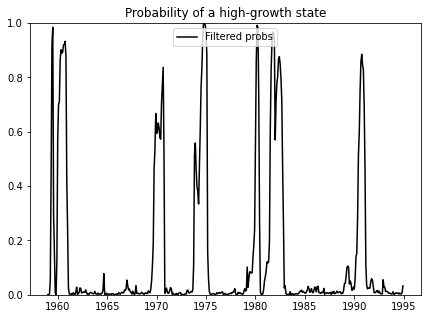

In [147]:
#results.smoothed_regime_probs[0]
%matplotlib inline
from matplotlib import pyplot as plt

# Filtering and smoothing of the data

years = np.arange(1959, 1995 + 2/12, 1/12)[:results.smoothed_regime_probs[0].shape[0]]
smoothed_high_growth_state_probs = results.smoothed_regime_probs[0]
#smoothed_high_growth_state_probs = 

# Plot the result

f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(7,5))

ax1.set_ylim((0, 1))
ax1.set_title('Probability of a high-growth state')

ax1.plot(years, smoothed_high_growth_state_probs, 'k', label='Filtered probs')
ax1.legend(loc='upper center')

# Comparison params

In [148]:
start_params1 = np.array([0.8337, 0.0275, 0.5   ,  0.5   ,  0.5   ,  0.5   ,  0.    ,
        0.    ,  0.4242, -0.0303,  0.4242, -0.0303,  0.4242, -0.0303,
        0.4242, -0.0303,  0.4242, -0.0303,  0.25  ,  0.25  ,  0.25  ,
        0.25  , -1.8   ,  0.5   ])

In [149]:
np.array(params.mlefit.params)

array([ 1.61223297, -3.5663317 ,  0.63747402,  0.33877626,  0.42960694,
        0.52235016, -0.01628516,  0.14544058,  0.36259509, -0.03758953,
       -0.06700339, -0.05568814, -0.31803176, -0.0746511 , -0.41121401,
       -0.19293359,  0.03321909,  0.34595982,  0.52160962,  0.85775842,
        0.7388354 ,  0.57904449, -1.41196303,  0.23214575])

In [150]:
start_params

array([ 0.8808,  0.0474,  0.5   ,  0.5   ,  0.5   ,  0.5   ,  0.    ,
        0.    ,  0.4242, -0.0303,  0.4242, -0.0303,  0.4242, -0.0303,
        0.4242, -0.0303,  0.4242, -0.0303,  0.25  ,  0.25  ,  0.25  ,
        0.25  , -1.8   ,  0.5   ])